# HW9 Digit Classification with KNN and Final Project Updates


In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. 

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

from scipy.io import arff

# Load ARFF file
mnist, meta = arff.loadarff('mnist_784.arff')
'''
ARFF (Attribute-Relation File Format) files are often used in the Weka machine learning software. 
The function returns two objects: mnist containing the data, and meta containing metadata about the dataset.

mnist: This object contains the actual data from the ARFF file. It is usually in the form of a structured 
numpy array where each column represents a feature or attribute of the data, and each row represents an 
individual data instance or record. In the case of the MNIST dataset, each row would typically represent 
an image of a handwritten digit, with the features being the pixel values of the image along with possibly 
a label for the digit (0 through 9).

meta: This object contains metadata about the dataset. Metadata is essentially "data about data"; 
in this scenario, it includes information about the attributes or features in the dataset. For example, 
the metadata could describe the name, type (numeric, nominal, string, etc.), and other properties of each 
attribute in the dataset. For the MNIST dataset, metadata might describe the pixel value fields (indicating 
their data type as integer or float), and a label field (indicating it as categorical with possible values 
from 0 to 9).
'''

# # Convert data to DataFrame (optional)
# import pandas as pd
# df = pd.DataFrame(data)

from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
"""
This line changes the default SSL context to one that does not verify SSL certificates. 
It is useful when fetching data from URLs that might have SSL certificate issues, 
but it should be used with caution as it makes the connection less secure.
"""

# Load MNIST Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, parser='auto')

# Prepare Data Arrays
X, Y = mnist.data, mnist.target
"""
Splits the fetched data into feature data (X) and target labels (Y).
"""
# Rescale grayscale values to [0,1]
X = X / 255.0


# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
X = X.to_numpy()
Y = Y.to_numpy()
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]
'''
Applies the permutation to X and Y to shuffle the data, 
ensuring that the model does not learn any order-specific biases.
'''

print('data shape:', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
'''
This section splits the shuffled data into different subsets for training, 
development (or validation), and testing. The training set is the main dataset 
used to train models. The development set is used to tune model parameters, and 
the test set is used to evaluate model performance after training. The "mini" 
train set is a smaller subset of the training data, often used for quick experiments 
or when computational resources are limited.
'''
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]


data shape: (70000, 784)
label shape: (70000,)


In [3]:
print(type(X))
print(type(Y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

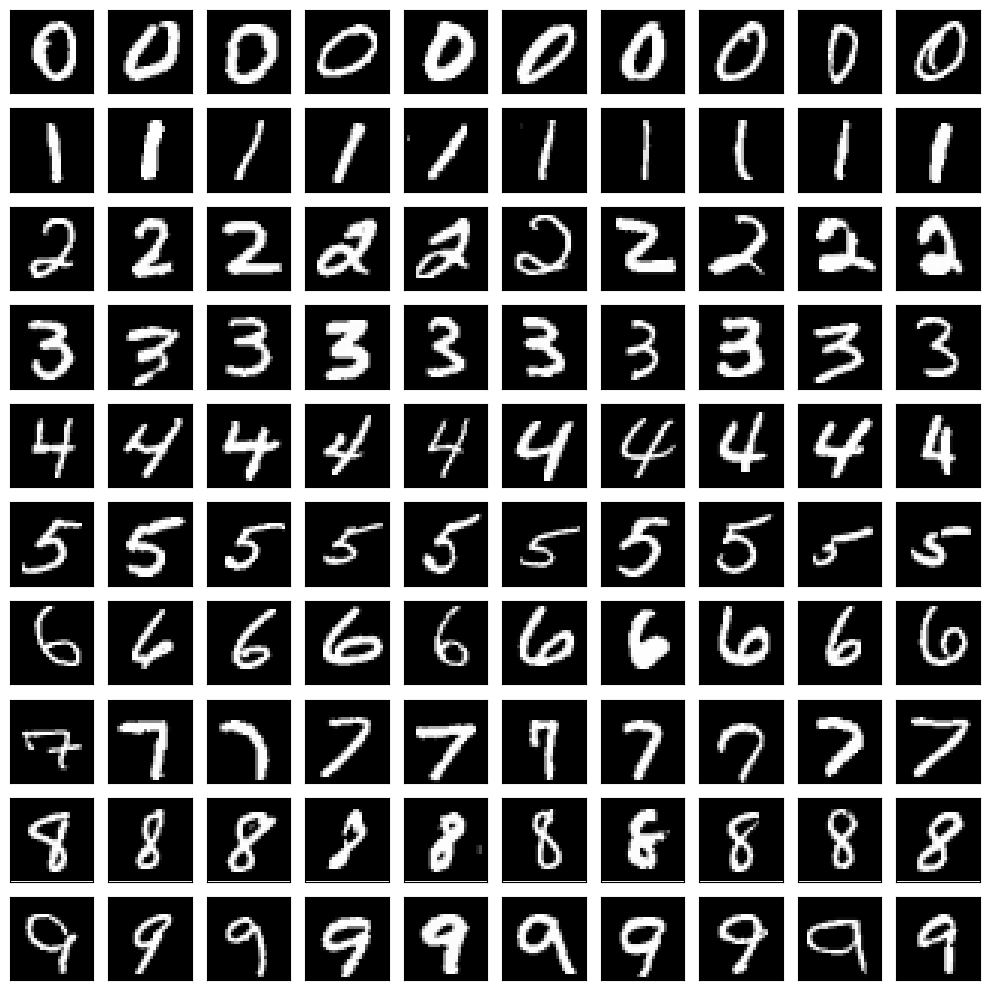

In [4]:
# Convert labels to integers for indexing
Y = Y.astype(int)

# Reshape data to 28x28 pixels
X = X.reshape(-1, 28, 28)

# Set default colormap to grayscale
plt.rc('image', cmap='gray')

# Initialize a 10x10 grid of subplots
fig, axes = plt.subplots(10, 10, figsize=(10, 10))

# Hide axis ticks and labels on all subplots
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# Populate subplots with the first 10 examples of each digit
for digit in range(10):
    digit_mask = (Y == digit)  # Filter examples for current digit
    digit_images = X[digit_mask][:10]  # Get first 10 images
    for i, image in enumerate(digit_images):
        axes[digit, i].imshow(image, interpolation='nearest')  # Display image in subplot

# Adjust layout to prevent overlap of subplot elements
plt.tight_layout()

# Display the plot
plt.show()

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [5]:
k_values = [1, 3, 5, 7, 9]

# Initialize accuracy storage
accuracy_dev_set = {}

for k in k_values:
    # Setup KNN, train, and make predictions
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(mini_train_data, mini_train_labels)
    dev_predicted = knn.predict(dev_data)
    
    # Calculate accuracy
    accuracy_dev_set[k] = np.mean(dev_labels == dev_predicted)
    
    # Get detailed metrics for k=1
    if k == 1:
        detailed_report_for_k1 = classification_report(dev_labels, dev_predicted)
        
print(f"Accuracy on the Dev Set: {accuracy_dev_set} \n")
print(f"Precision, Recall, and F1 for K=1: \n{detailed_report_for_k1}")

print("Most Difficult Digit to Predict: 9")

Accuracy on the Dev Set: {1: 0.884, 3: 0.876, 5: 0.882, 7: 0.877, 9: 0.875} 

Precision, Recall, and F1 for K=1: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

Most Difficult Digit to Predict: 9


(3) Project updates! Prepare a ppt deck for class! 